# Monte Carlo methods

Generally speaking Monte Carlo control is characterised by approximating the value function of state action pairs by using sample approximations for their rewards. In other words we learn the optimal policy by exploring the average over rewards observed previously for states and exploiting them.

In particular the Monte Carlo approach doesn't bootstrap the value function but instead observes a full episode before it updates its value functions.

### Control equations

- Cumulative reward:  
$G_t = γ * G_{t+1} + R_t$

- State action values:  
$Q(s, a) = Σ G(s, a) / N(s, a)$

- Non-stationary updates:  
$Q(s, a) = Q(s, a) + α * (G - Q(s, a))$

### The blackjack gym

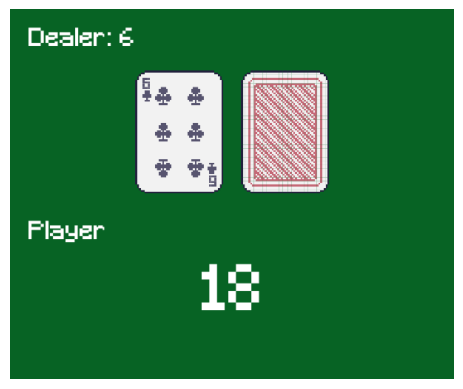

In [ ]:
# env = gym.make("CartPole-v1",render_mode='rgb_array')

env = gym.make('Blackjack-v1',render_mode='rgb_array')

for episode in range(10):
    state = env.reset()
    done = False
    
    while not done:
        img = plt.imshow(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        state = observation

env.close()

In [ ]:
import gym
from gym import wrappers

# from __future__ import annotations

from collections import defaultdict
from typing import Tuple, List

import numpy as np
from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Learning the value function

A psuedo algorithm for learning the value function using monte carlo methods is roughly;  

- Initialise
- while episode running:
    - take a step using policy and observe S0
    - for each step:
        - rewards = gamma*rewards + return
        - append state_history {state: rewards}
        - value[state] = mean(state_history[state])

A key nugget here is that the monte carlo approach can only reflect on the merits of its decisions once an episode has finished and the states observed. Unless of course the agent visits a single state more than once within the same episode.

There are some merits to updating the value function as often as possible when running many agents concurrently in async while updating the same value functions.

Key traits:  
- the value function is not used when estimating improvements, we only average past experience  
- mostly assumes the statespace is of reasonable size and discrete (as it actively stores state values, atleast in its simplest form)  
- assumes a soft policy function with coverage, that is enters all states infinitely many times 
- alpha can be set to 1/n if we whish to use the sample mean (X bar) estimate for state rewards, alpha [0,1) fits non-stationary distributions

In [ ]:
class agent:
    rewards = []
    errors = []
    episode = 0
    
    def update(self):
        pass

    def get_action(self):
        pass

    def anneal_epsilon(self, min_epsilon=0.01, max_epsilon=0.1, decay_rate=0.01):
        self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * self.episode)

    def moving_average(self, x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    def plot(self):
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        axs[0].set_title("Average Reward")
        axs[0].plot(list(range(len(self.moving_average(self.rewards,500)))),self.moving_average(self.rewards,500))

        axs[1].set_title("Temporal diff error")
        axs[1].plot(list(range(len(self.moving_average(self.errors,500)))),self.moving_average(self.errors,500))

        plt.tight_layout()
        plt.show()

class MonteCarloAgent(agent):

    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.returns = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.visit_counts = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.episode = 0

    def update(self, episode_history: List[Tuple[Tuple[int, int, bool], int, int]]) -> None:
        self.episode += 1
        G = 0
        visited_states = set()

        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = self.gamma * G + reward

            if (state, action) not in visited_states:
                visited_states.add((state, action))
                self.visit_counts[state][action] += 1
                self.returns[state][action] += G
                #update in the stationary distribution
                # self.q_table[state][action] = self.returns[state][action] / self.visit_counts[state][action]

                error = self.alpha * (G - self.q_table[state][action])
                self.q_table[state][action] += error

                self.errors.append(error)

        self.anneal_epsilon()

    def get_action(self, state: Tuple[int, int, bool]) -> int:
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def get_q_table(self):
        return self.q_table


$G_t = γ * G_{t+1} + R_t$

where:

G_t is the return (cumulative reward) at time step t.  
γ is the discount factor, represented by self.gamma in the code.  
G_{t+1} is the return (cumulative reward) at the next time step (t+1).  
R_t is the immediate reward at time step t, represented by reward in the code.  

$Q(s, a) = Q(s, a) + α * (G - Q(s, a))$

where:

Q(s, a) is the action-value function for state s and action a, represented by self.q_table[state][action] in the code.  
G is the return (cumulative reward) for the current episode.  
α is the step-size parameter (learning rate), represented by self.alpha in the code.  


History is replayed in reverse to learn after an episode finishes:  
```
for t in reversed(range(len(episode_history))):
    state, action, reward = episode_history[t]
```


In [ ]:


num_episodes = 100_000
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)
mc_agent = MonteCarloAgent(env, gamma=0.95, epsilon=0.1)
for _ in range(num_episodes):
    state, trunc = env.reset()
    done = False
    episode_history = []

    while not done:
        action = mc_agent.get_action(state)
        next_state, reward, done, _, info = env.step(action)
        episode_history.append((state, action, reward))
        state = next_state

    mc_agent.update(episode_history)
    mc_agent.rewards.append(reward)


/mnt/c/Users/user/Documents/openai_gym_projects/gym/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


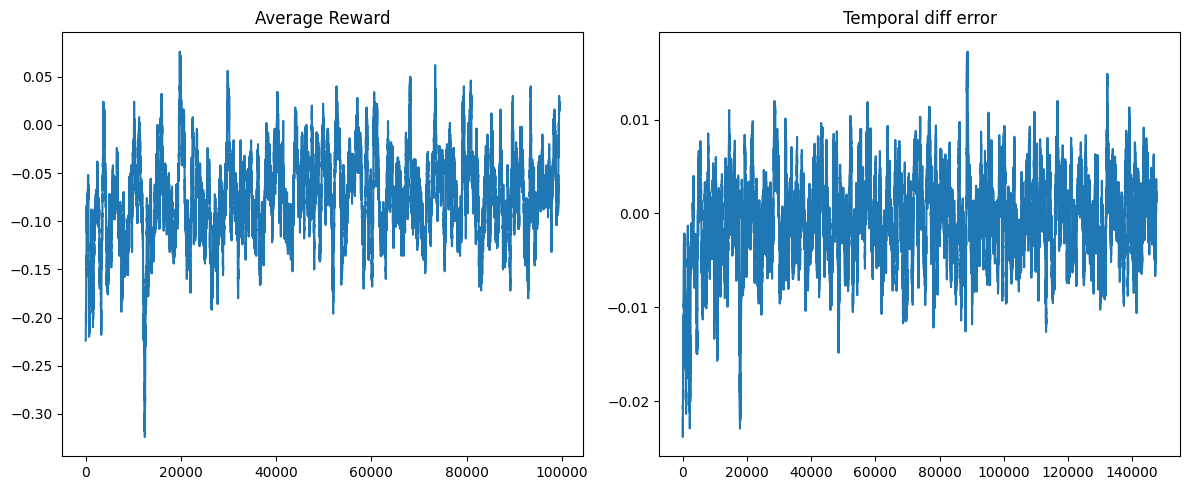

In [ ]:
mc_agent.plot()